# Long Short-Term Memory (LSTM) para Análisis de Series de Tiempo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from statsmodels.tsa.seasonal import seasonal_decompose
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
tf.random.set_seed(21562)

# Preparación de datos

Cargamos los datos

In [3]:
df = pd.read_csv('data/precios.csv', parse_dates=['Fecha'], index_col='Fecha')

In [4]:
df.head()

,Super,Regular,Diesel
Fecha,,,
2002-01-01,12.55,12.19,8.95
2002-02-01,12.29,11.90,8.66
2002-03-01,12.58,12.17,8.69
2002-04-01,14.11,13.71,9.38
2002-05-01,14.16,13.79,9.44


Visualización de los datos

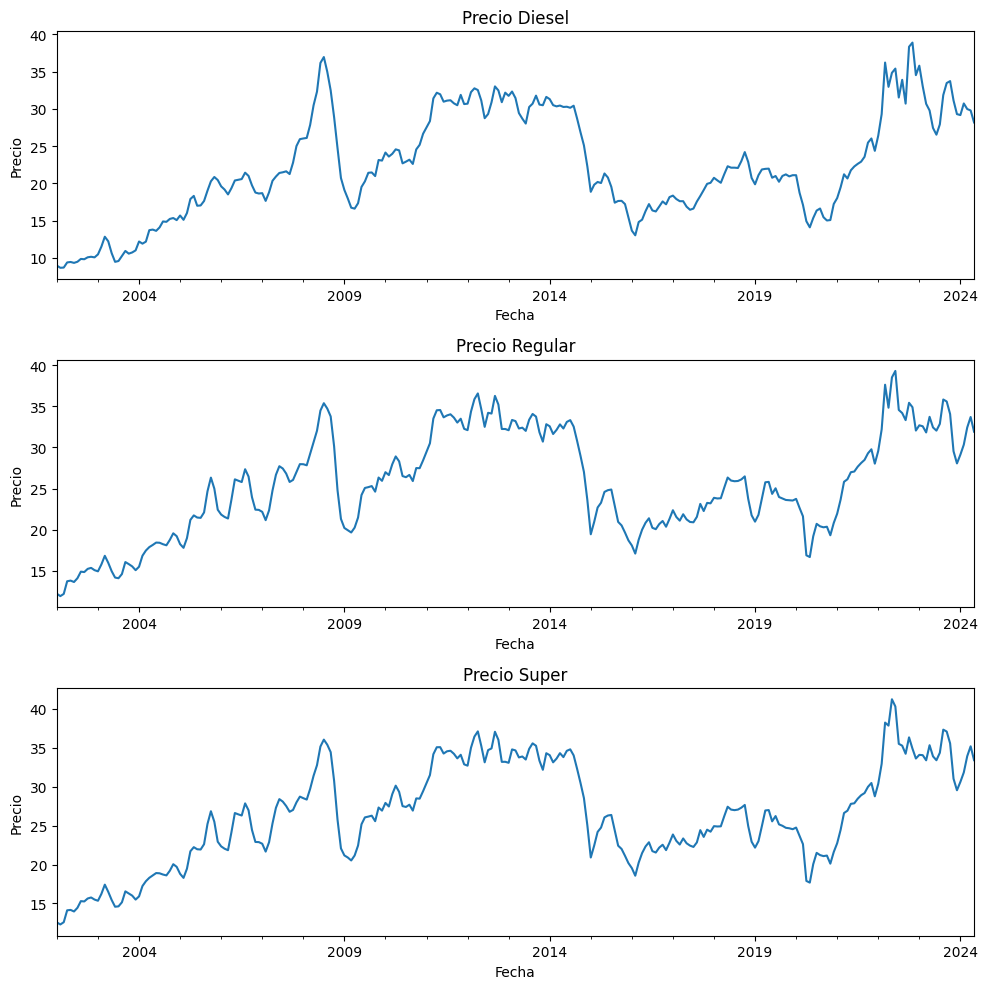

In [5]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

df['Diesel'].plot(
    ax=ax[0],
    title='Precio Diesel',
    xlabel='Fecha',
    ylabel='Precio'
)

df['Regular'].plot(
    ax=ax[1],
    title='Precio Regular',
    xlabel='Fecha',
    ylabel='Precio'
)

df['Super'].plot(
    ax=ax[2],
    title='Precio Super',
    xlabel='Fecha',
    ylabel='Precio'
)

plt.tight_layout()

plt.show()

Descompocisión de la serie de tiempo

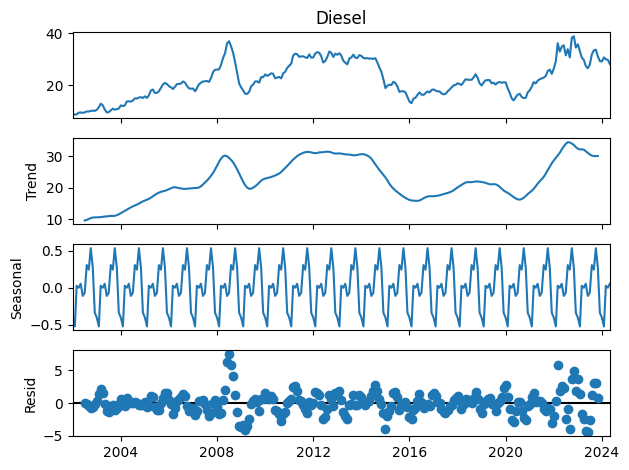

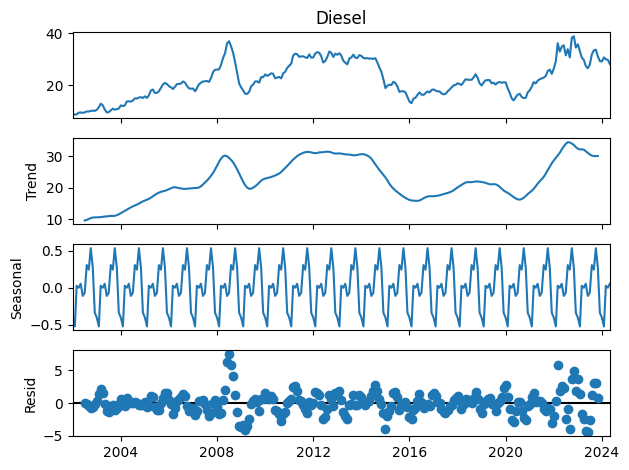

In [6]:
seasonal_decompose(df['Diesel'], model='additive', period=12).plot()

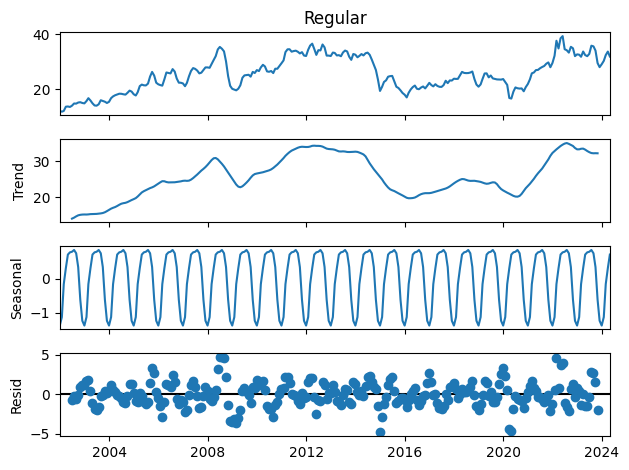

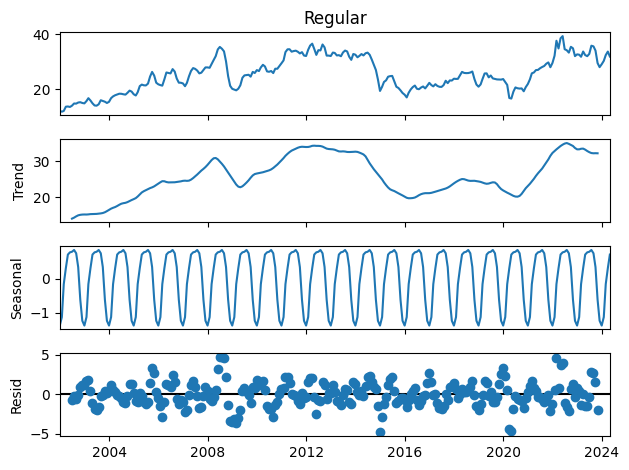

In [7]:
seasonal_decompose(df['Regular'], model='additive', period=12).plot()

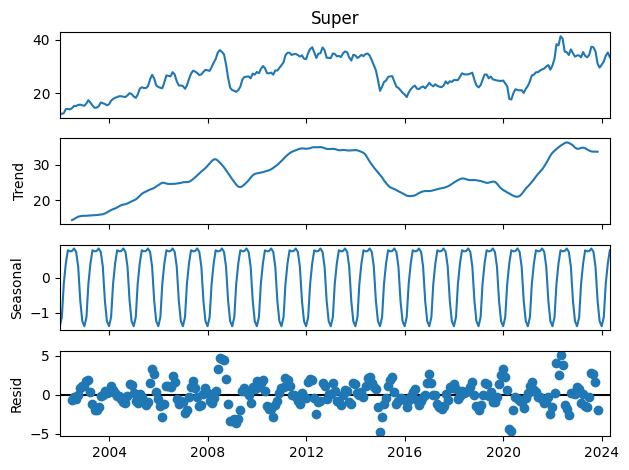

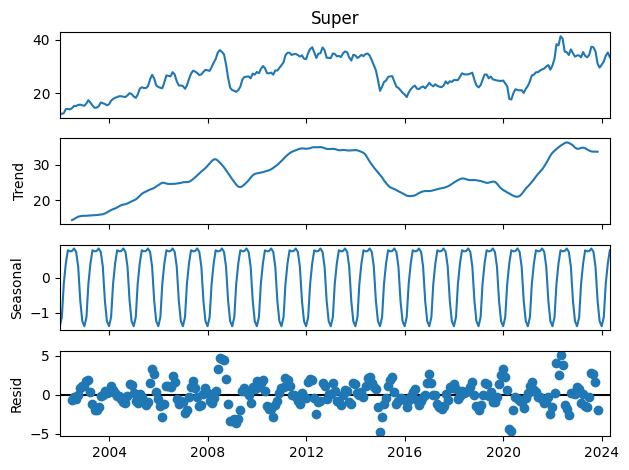

In [8]:
seasonal_decompose(df['Super'], model='additive', period=12).plot()

Diferenciación de la serie de tiempo

In [9]:
df['Diesel_diff'] = df['Diesel'].diff()

In [10]:
df['Regular_diff'] = df['Regular'].diff()

In [11]:
df['Super_diff'] = df['Super'].diff()

Esta función será para revertir la diferenciación

Eliminamos los valores nulos

In [12]:
df.dropna(inplace=True)

In [13]:
df.head()

,Super,Regular,Diesel,Diesel_diff,Regular_diff,Super_diff
Fecha,,,,,,
2002-02-01,12.29,11.90,8.66,-0.29,-0.29,-0.26
2002-03-01,12.58,12.17,8.69,0.03,0.27,0.29
2002-04-01,14.11,13.71,9.38,0.69,1.54,1.53
2002-05-01,14.16,13.79,9.44,0.06,0.08,0.05
2002-06-01,13.96,13.62,9.32,-0.12,-0.17,-0.20


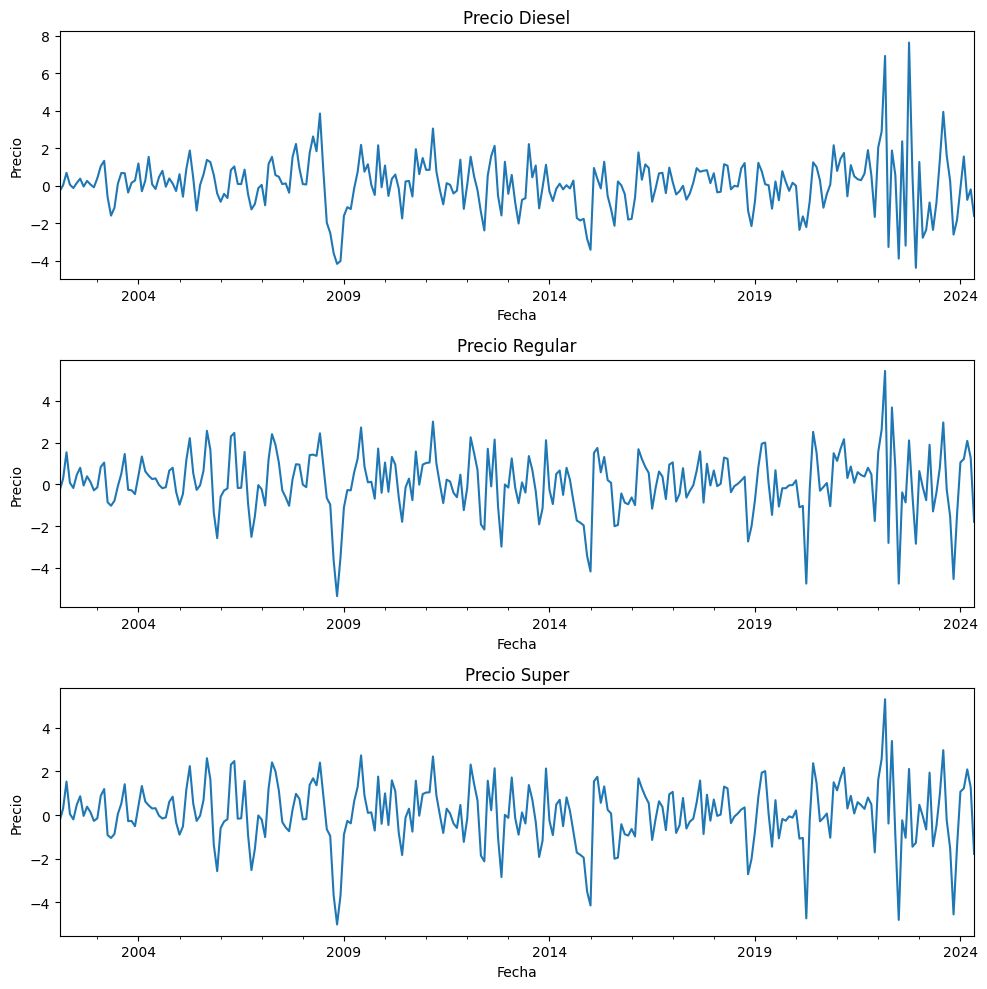

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(10, 10))

df['Diesel_diff'].plot(
    ax=ax[0],
    title='Precio Diesel',
    xlabel='Fecha',
    ylabel='Precio'
)

df['Regular_diff'].plot(
    ax=ax[1],
    title='Precio Regular',
    xlabel='Fecha',
    ylabel='Precio'
)

df['Super_diff'].plot(
    ax=ax[2],
    title='Precio Super',
    xlabel='Fecha',
    ylabel='Precio'
)

plt.tight_layout()

Normalización de los datos

In [15]:
scaler = MinMaxScaler(
    feature_range=(0, 1)
)

In [16]:
diesel_data = df['Diesel_diff'].values.reshape(-1, 1)
diesel_data = scaler.fit_transform(diesel_data)

In [17]:
regular_data = df['Regular_diff'].values.reshape(-1, 1)
regular_data = scaler.fit_transform(regular_data)

In [18]:
super_data = df['Super_diff'].values.reshape(-1, 1)
super_data = scaler.fit_transform(super_data)

Creación de secuencias

In [19]:
def create_sequences(data, seq_length=1, train_size=0.6, val_size=0.2, test_size=0.2):
    """
    Crea secuencias de datos "supervisados". Se crea una matriz bidimensional donde la dimennsión 0 es t-1 y la dimensión 1 es t.
    :param data: 
    :param seq_length: 
    :return: 
    """
    train_idx = int(len(data) * train_size)
    val_idx = int(len(data) * (train_size + val_size))

    train_data = data[:train_idx]
    val_data = data[train_idx:val_idx]
    test_data = data[val_idx:]

    X_train, y_train = [], []
    X_val, y_val = [], []
    X_test, y_test = [], []

    for i in range(seq_length, len(train_data)):
        X_train.append(train_data[i - seq_length:i, 0])
        y_train.append(train_data[i, 0])

    for i in range(seq_length, len(val_data)):
        X_val.append(val_data[i - seq_length:i, 0])
        y_val.append(val_data[i, 0])

    for i in range(seq_length, len(test_data)):
        X_test.append(test_data[i - seq_length:i, 0])
        y_test.append(test_data[i, 0])
        
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_val, y_val = np.array(X_val), np.array(y_val)
    X_test, y_test = np.array(X_test), np.array(y_test)

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_val, y_val, X_test, y_test

In [20]:
diesel_split = create_sequences(diesel_data)

X_train_diesel = diesel_split[0]
y_train_diesel = diesel_split[1]
X_val_diesel = diesel_split[2]
y_val_diesel = diesel_split[3]
X_test_diesel = diesel_split[4]
y_test_diesel = diesel_split[5]

In [21]:
regular_split = create_sequences(regular_data)

X_train_regular = regular_split[0]
y_train_regular = regular_split[1]
X_val_regular = regular_split[2]
y_val_regular = regular_split[3]
X_test_regular = regular_split[4]
y_test_regular = regular_split[5]

In [22]:
super_split = create_sequences(super_data)

X_train_super = super_split[0]
y_train_super = super_split[1]
X_val_super = super_split[2]
y_val_super = super_split[3]
X_test_super = super_split[4]
y_test_super = super_split[5]

## Modelo LSTM

### Versión 1
Se ha realizado un modelo donde la primera capa LSTM tiene 50 neuronas y retorna secuencias. La segunda capa LSTM tiene 50 neuronas y no retorna secuencias. Se ha añadido una capa densa de 25 neuronas y una capa de salida.

#### Diesel

In [23]:
def create_model_diesel(lstm_units=50, dense_units=25):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X_train_diesel.shape[1], X_train_diesel.shape[2])),
        tf.keras.layers.LSTM(lstm_units, return_sequences=True),
        tf.keras.layers.LSTM(lstm_units, return_sequences=False),
        tf.keras.layers.Dense(dense_units),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [24]:
model_diesel = KerasRegressor(model=create_model_diesel, verbose=0)

In [25]:
param_grid_diesel = {
    'model__lstm_units': [50, 100],
    'model__dense_units': [25, 50],
    'batch_size': [32, 64],
    'epochs': [50, 100]    
}

grid_diesel = GridSearchCV(estimator=model_diesel, param_grid=param_grid_diesel, cv=3, verbose=1, n_jobs=-1)

In [26]:
grid_result_diesel = grid_diesel.fit(X_train_diesel, y_train_diesel, validation_data=(X_val_diesel, y_val_diesel))

print(f"Mejor resultado: {grid_result_diesel.best_score_} usando {grid_result_diesel.best_params_}")

best_model_diesel = grid_result_diesel.best_estimator_

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Mejor resultado: 0.117776413482657 usando {'batch_size': 32, 'epochs': 50, 'model__dense_units': 50, 'model__lstm_units': 50}


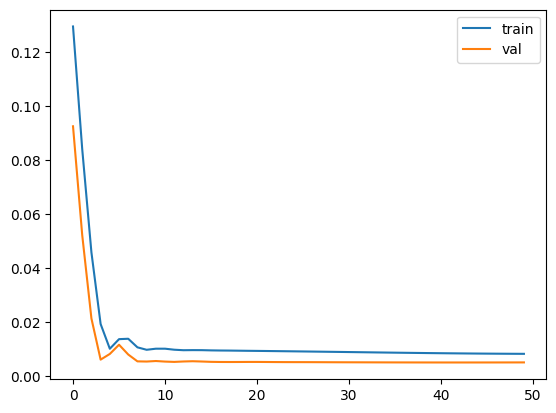

In [27]:
plt.plot(best_model_diesel.history_['loss'], label='train')
plt.plot(best_model_diesel.history_['val_loss'], label='val')
plt.legend()
plt.show()

In [91]:
y_pred_diesel = best_model_diesel.predict(X_test_diesel)
y_pred_diesel = y_pred_diesel.reshape(-1, 1)
y_pred_diesel_v1 = scaler.inverse_transform(y_pred_diesel)
y_test_diesel_normal_v1 = scaler.inverse_transform(y_test_diesel.copy().reshape(-1, 1))

In [92]:
y_pred_diesel_v1_shifted = y_pred_diesel_v1[1:]
last_sequence = X_test_diesel[-1]
next_prediction = best_model_diesel.predict(last_sequence.reshape(1, last_sequence.shape[0], last_sequence.shape[1]))
y_pred_diesel_v1_shifted = np.append(y_pred_diesel_v1_shifted, next_prediction)
y_pred_diesel_v1_shifted = y_pred_diesel_v1_shifted.reshape(-1, 1)

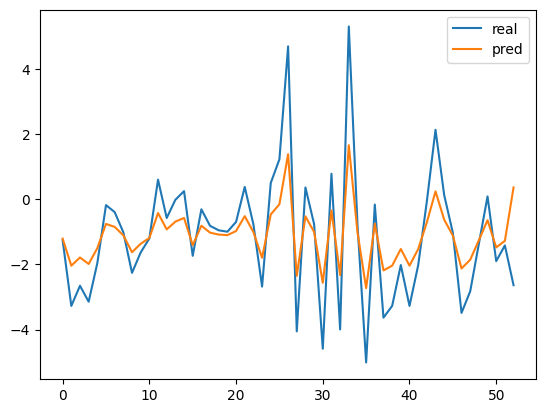

In [93]:
plt.plot(y_test_diesel_normal_v1, label='real')
plt.plot(y_pred_diesel_v1_shifted, label='pred')
plt.legend()
plt.show()

#### Regular

In [30]:
def create_model_regular(lstm_units=50, dense_units=25):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X_train_regular.shape[1], X_train_regular.shape[2])),
        tf.keras.layers.LSTM(lstm_units, return_sequences=True),
        tf.keras.layers.LSTM(lstm_units, return_sequences=False),
        tf.keras.layers.Dense(dense_units),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [31]:
model_regular = KerasRegressor(model=create_model_regular, verbose=0)

In [32]:
param_grid_regular = {
    'model__lstm_units': [50, 100],
    'model__dense_units': [25, 50],
    'batch_size': [32, 64],
    'epochs': [50, 100]    
}

grid_regular = GridSearchCV(estimator=model_regular, param_grid=param_grid_regular, cv=3, verbose=1, n_jobs=-1)

In [33]:
grid_result_regular = grid_regular.fit(X_train_regular, y_train_regular, validation_data=(X_val_regular, y_val_regular))

print(f"Mejor resultado: {grid_result_regular.best_score_} usando {grid_result_regular.best_params_}")

best_model_regular = grid_result_regular.best_estimator_

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Mejor resultado: 0.16236759760835295 usando {'batch_size': 32, 'epochs': 50, 'model__dense_units': 50, 'model__lstm_units': 100}


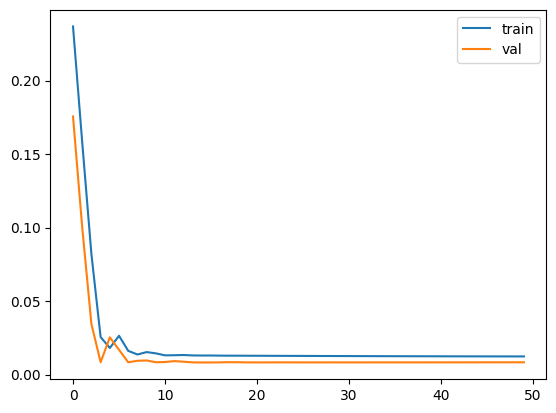

In [34]:
plt.plot(best_model_regular.history_['loss'], label='train')
plt.plot(best_model_regular.history_['val_loss'], label='val')
plt.legend()
plt.show()

In [74]:
y_pred_regular = best_model_regular.predict(X_test_regular)
y_pred_regular = y_pred_regular.reshape(-1, 1)
y_pred_regular_v1 = scaler.inverse_transform(y_pred_regular)
y_test_regular_normal_v1 = scaler.inverse_transform(y_test_regular.copy().reshape(-1, 1))

In [94]:
y_pred_regular_v1_shifted = y_pred_regular_v1[1:]
last_sequence = X_test_regular[-1]
next_prediction = best_model_regular.predict(last_sequence.reshape(1, last_sequence.shape[0], last_sequence.shape[1]))
y_pred_regular_v1_shifted = np.append(y_pred_regular_v1_shifted, next_prediction)
y_pred_regular_v1_shifted = y_pred_regular_v1_shifted.reshape(-1, 1)

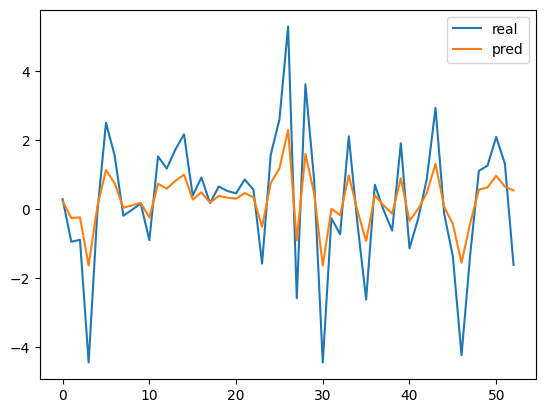

In [95]:
plt.plot(y_test_regular_normal_v1, label='real')
plt.plot(y_pred_regular_v1_shifted, label='pred')
plt.legend()
plt.show()

#### Super

In [37]:
def create_model_super(lstm_units=50, dense_units=25):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X_train_super.shape[1], X_train_super.shape[2])),
        tf.keras.layers.LSTM(lstm_units, return_sequences=True),
        tf.keras.layers.LSTM(lstm_units, return_sequences=False),
        tf.keras.layers.Dense(dense_units),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [38]:
model_super = KerasRegressor(model=create_model_super, verbose=0)

In [39]:
param_grid_super = {
    'model__lstm_units': [50, 100],
    'model__dense_units': [25, 50],
    'batch_size': [32, 64],
    'epochs': [50, 100]    
}

grid_super = GridSearchCV(estimator=model_super, param_grid=param_grid_super, cv=3, verbose=1, n_jobs=-1)

In [40]:
grid_result_super = grid_super.fit(X_train_super, y_train_super, validation_data=(X_val_super, y_val_super))

print(f"Mejor resultado: {grid_result_super.best_score_} usando {grid_result_super.best_params_}")

best_model_super = grid_result_super.best_estimator_

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Mejor resultado: 0.16593676053802697 usando {'batch_size': 64, 'epochs': 100, 'model__dense_units': 50, 'model__lstm_units': 100}


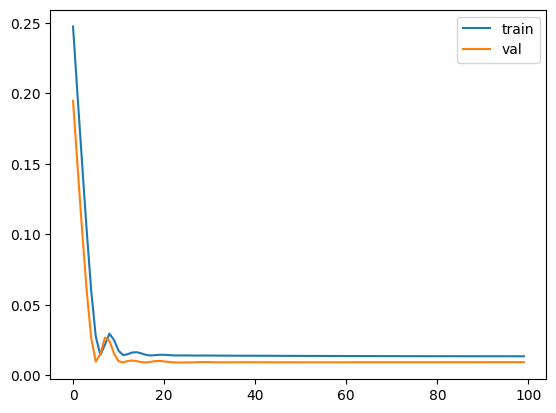

In [41]:
plt.plot(best_model_super.history_['loss'], label='train')
plt.plot(best_model_super.history_['val_loss'], label='val')
plt.legend()
plt.show()

In [42]:
y_pred_super = best_model_super.predict(X_test_super)
y_pred_super = y_pred_super.reshape(-1, 1)
y_pred_super_v1 = scaler.inverse_transform(y_pred_super)
y_test_super_normal_v1 = scaler.inverse_transform(y_test_super.copy().reshape(-1, 1))

In [96]:
y_pred_super_v1_shifted = y_pred_super_v1[1:]
last_sequence = X_test_super[-1]
next_prediction = best_model_super.predict(last_sequence.reshape(1, last_sequence.shape[0], last_sequence.shape[1]))
y_pred_super_v1_shifted = np.append(y_pred_super_v1_shifted, next_prediction)
y_pred_super_v1_shifted = y_pred_super_v1_shifted.reshape(-1, 1)

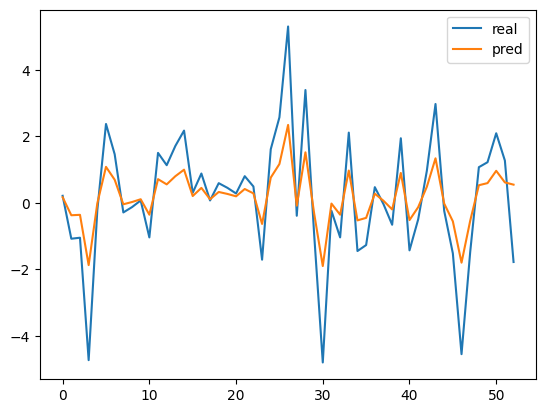

In [97]:
plt.plot(y_test_super_normal_v1, label='real')
plt.plot(y_pred_super_v1_shifted, label='pred')
plt.legend()
plt.show()

### Versión 2
Se ha realizado una LSTM de 50 neuronas que retorna secuencias, para luego hacer un dropout de 0.2. Procede a una capa LSTM bidireccional de 50 neuronas que no retorna secuencias. Se añade un dropout de 0.2 y una capa densa de 25 neuronas. Finalmente, se añade una capa de salida.

#### Diesel

In [44]:
def create_model_diesel_v2(lstm_units=50, dense_units=25, dropout_rate=0.2):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X_train_diesel.shape[1], X_train_diesel.shape[2])),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=False)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(dense_units, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [45]:
model_diesel_v2 = KerasRegressor(model=create_model_diesel_v2, verbose=0)

In [46]:
param_grid_diesel_v2 = {
    'model__lstm_units': [50, 100],
    'model__dense_units': [25, 50],
    'model__dropout_rate': [0.2, 0.3],
    'batch_size': [32, 64],
    'epochs': [50, 100]
}

grid_diesel_v2 = GridSearchCV(estimator=model_diesel_v2, param_grid=param_grid_diesel_v2, cv=3, verbose=1, n_jobs=-1)

In [47]:
grid_result_diesel_v2 = grid_diesel_v2.fit(X_train_diesel, y_train_diesel, validation_data=(X_val_diesel, y_val_diesel))

print(f"Mejor resultado: {grid_result_diesel_v2.best_score_} usando {grid_result_diesel_v2.best_params_}")

best_model_diesel_v2 = grid_result_diesel_v2.best_estimator_

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Mejor resultado: 0.14347881613253774 usando {'batch_size': 64, 'epochs': 50, 'model__dense_units': 25, 'model__dropout_rate': 0.3, 'model__lstm_units': 50}


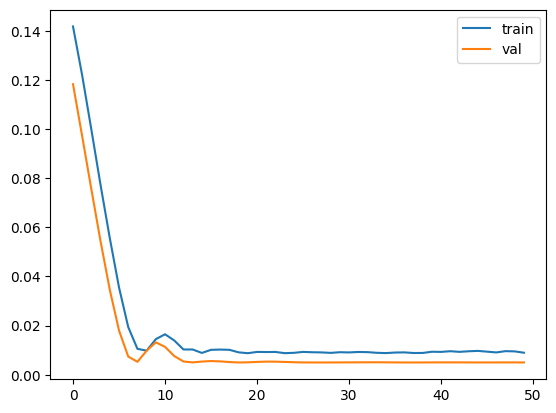

In [48]:
plt.plot(best_model_diesel_v2.history_['loss'], label='train')
plt.plot(best_model_diesel_v2.history_['val_loss'], label='val')
plt.legend()
plt.show()

In [49]:
y_pred_diesel_v2 = best_model_diesel_v2.predict(X_test_diesel)
y_pred_diesel_v2 = y_pred_diesel_v2.reshape(-1, 1)
y_pred_diesel_v2 = scaler.inverse_transform(y_pred_diesel_v2)
y_test_diesel_v2_normal = scaler.inverse_transform(y_test_diesel.copy().reshape(-1, 1))

In [98]:
y_pred_diesel_v2_shifted = y_pred_diesel_v2[1:]
last_sequence = X_test_diesel[-1]
next_prediction = best_model_diesel_v2.predict(last_sequence.reshape(1, last_sequence.shape[0], last_sequence.shape[1]))
y_pred_diesel_v2_shifted = np.append(y_pred_diesel_v2_shifted, next_prediction)
y_pred_diesel_v2_shifted = y_pred_diesel_v2_shifted.reshape(-1, 1)

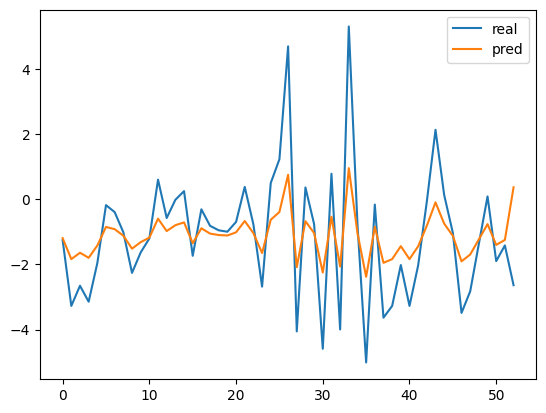

In [99]:
plt.plot(y_test_diesel_v2_normal, label='real')
plt.plot(y_pred_diesel_v2_shifted, label='pred')
plt.legend()
plt.show()

#### Regular

In [51]:
def create_model_regular_v2(lstm_units=50, dense_units=25, dropout_rate=0.2):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X_train_regular.shape[1], X_train_regular.shape[2])),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=False)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(dense_units, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [52]:
model_regular_v2 = KerasRegressor(model=create_model_regular_v2, verbose=0)

In [53]:
param_grid_regular_v2 = {
    'model__lstm_units': [50, 100],
    'model__dense_units': [25, 50],
    'model__dropout_rate': [0.2, 0.3],
    'batch_size': [32, 64],
    'epochs': [50, 100]
}

grid_regular_v2 = GridSearchCV(estimator=model_regular_v2, param_grid=param_grid_regular_v2, cv=3, verbose=1, n_jobs=-1)

In [54]:
grid_result_regular_v2 = grid_regular_v2.fit(X_train_regular, y_train_regular, validation_data=(X_val_regular, y_val_regular))

print(f"Mejor resultado: {grid_result_regular_v2.best_score_} usando {grid_result_regular_v2.best_params_}")

best_model_regular_v2 = grid_result_regular_v2.best_estimator_

Fitting 3 folds for each of 32 candidates, totalling 96 fits


D:\UVG\DataScience\GUA-Gasoline-Analysis\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejor resultado: 0.18225263616932486 usando {'batch_size': 64, 'epochs': 50, 'model__dense_units': 50, 'model__dropout_rate': 0.3, 'model__lstm_units': 100}


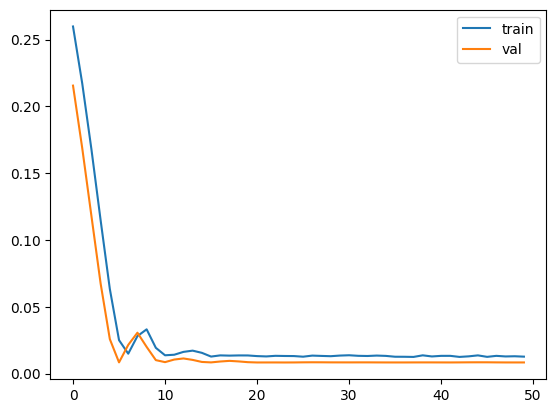

In [55]:
plt.plot(best_model_regular_v2.history_['loss'], label='train')
plt.plot(best_model_regular_v2.history_['val_loss'], label='val')
plt.legend()
plt.show()

In [56]:
y_pred_regular_v2 = best_model_regular_v2.predict(X_test_regular)
y_pred_regular_v2 = y_pred_regular_v2.reshape(-1, 1)
y_pred_regular_v2 = scaler.inverse_transform(y_pred_regular_v2)
y_test_regular_v2_normal = scaler.inverse_transform(y_test_regular.copy().reshape(-1, 1))

In [100]:
y_pred_regular_v2_shifted = y_pred_regular_v2[1:]
last_sequence = X_test_regular[-1]
next_prediction = best_model_regular_v2.predict(last_sequence.reshape(1, last_sequence.shape[0], last_sequence.shape[1]))
y_pred_regular_v2_shifted = np.append(y_pred_regular_v2_shifted, next_prediction)
y_pred_regular_v2_shifted = y_pred_regular_v2_shifted.reshape(-1, 1)

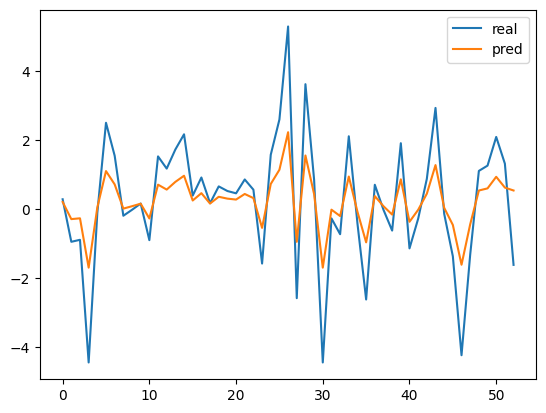

In [101]:
plt.plot(y_test_regular_v2_normal, label='real')
plt.plot(y_pred_regular_v2_shifted, label='pred')
plt.legend()
plt.show()

#### Super

In [58]:
def create_model_super_v2(lstm_units=50, dense_units=25, dropout_rate=0.2):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X_train_super.shape[1], X_train_super.shape[2])),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=False)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(dense_units, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [59]:
model_super_v2 = KerasRegressor(model=create_model_super_v2, verbose=0)

In [60]:
param_grid_super_v2 = {
    'model__lstm_units': [50, 100],
    'model__dense_units': [25, 50],
    'model__dropout_rate': [0.2, 0.3],
    'batch_size': [32, 64],
    'epochs': [50, 100]
}

grid_super_v2 = GridSearchCV(estimator=model_super_v2, param_grid=param_grid_super_v2, cv=3, verbose=1, n_jobs=-1)

In [61]:
grid_result_super_v2 = grid_super_v2.fit(X_train_super, y_train_super, validation_data=(X_val_super, y_val_super))

print(f"Mejor resultado: {grid_result_super_v2.best_score_} usando {grid_result_super_v2.best_params_}")

best_model_super_v2 = grid_result_super_v2.best_estimator_

Fitting 3 folds for each of 32 candidates, totalling 96 fits


D:\UVG\DataScience\GUA-Gasoline-Analysis\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejor resultado: 0.17996628629934464 usando {'batch_size': 64, 'epochs': 50, 'model__dense_units': 25, 'model__dropout_rate': 0.3, 'model__lstm_units': 100}


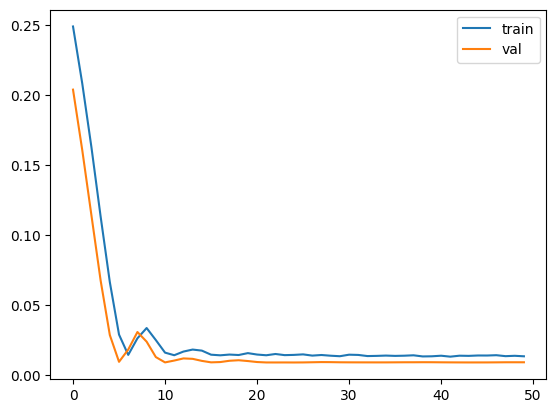

In [62]:
plt.plot(best_model_super_v2.history_['loss'], label='train')
plt.plot(best_model_super_v2.history_['val_loss'], label='val')
plt.legend()
plt.show()

In [63]:
y_pred_super_v2 = best_model_super_v2.predict(X_test_super)
y_pred_super_v2 = y_pred_super_v2.reshape(-1, 1)
y_pred_super_v2 = scaler.inverse_transform(y_pred_super_v2)
y_test_super_v2_normal = scaler.inverse_transform(y_test_super.copy().reshape(-1, 1))

In [102]:
y_pred_super_v2_shifted = y_pred_super_v2[1:]
last_sequence = X_test_super[-1]
next_prediction = best_model_super_v2.predict(last_sequence.reshape(1, last_sequence.shape[0], last_sequence.shape[1]))
y_pred_super_v2_shifted = np.append(y_pred_super_v2_shifted, next_prediction)
y_pred_super_v2_shifted = y_pred_super_v2_shifted.reshape(-1, 1)

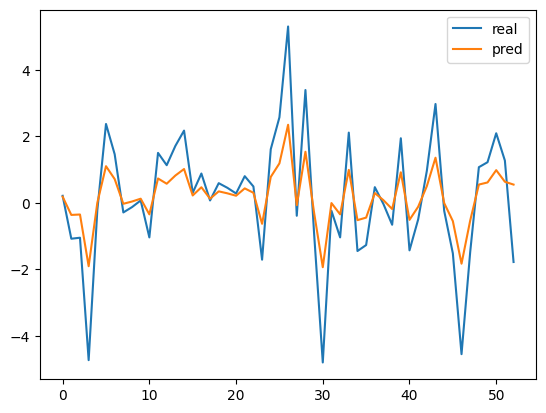

In [103]:
plt.plot(y_test_super_v2_normal, label='real')
plt.plot(y_pred_super_v2_shifted, label='pred')
plt.legend()
plt.show()

## Evaluación de Modelos

In [65]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [66]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

### Diesel

In [104]:
mse_diesel, mae_diesel, r2_diesel = evaluate_model(y_test_diesel_normal_v1, y_pred_diesel_v1_shifted)

In [106]:
mse_diesel_v2, mae_diesel_v2, r2_diesel_v2 = evaluate_model(y_test_diesel_v2_normal, y_pred_diesel_v1_shifted)

In [107]:
print(f"Versión 1: MSE={mse_diesel}, MAE={mae_diesel}, R2={r2_diesel}")
print(f"Versión 2: MSE={mse_diesel_v2}, MAE={mae_diesel_v2}, R2={r2_diesel_v2}")

Versión 1: MSE=1.4456251385476195, MAE=0.8925928051249779, R2=0.6261108703665619
Versión 2: MSE=1.4456251385476195, MAE=0.8925928051249779, R2=0.6261108703665619


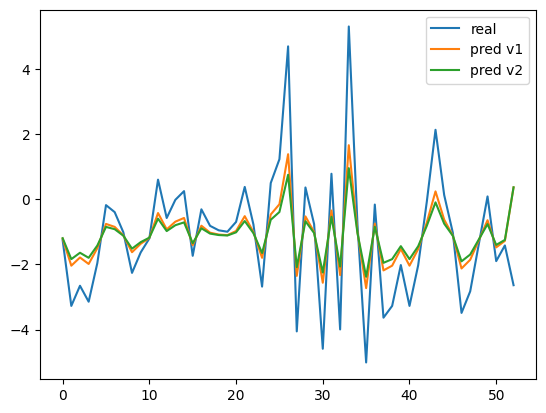

In [108]:
plt.plot(y_test_diesel_normal_v1, label='real')
plt.plot(y_pred_diesel_v1_shifted, label='pred v1')
plt.plot(y_pred_diesel_v2_shifted, label='pred v2')
plt.legend()
plt.show()

A pesar de tener predicciones similares, podemos observar el segundo modelo tener mejores resultados.

### Regular

In [109]:
mse_regular, mae_regular, r2_regular = evaluate_model(y_test_regular_normal_v1, y_pred_regular_v1_shifted)

In [110]:
mse_regular_v2, mae_regular_v2, r2_regular_v2 = evaluate_model(y_test_regular_v2_normal, y_pred_regular_v2_shifted)

In [111]:
print(f"Versión 1: MSE={mse_regular}, MAE={mae_regular}, R2={r2_regular}")
print(f"Versión 2: MSE={mse_regular_v2}, MAE={mae_regular_v2}, R2={r2_regular_v2}")

Versión 1: MSE=1.297963758193782, MAE=0.8480805918216483, R2=0.6234489814087074
Versión 2: MSE=1.2977036746026827, MAE=0.850222162008975, R2=0.62352443400939


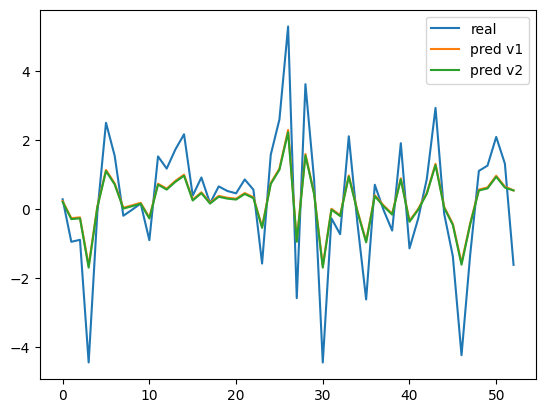

In [112]:
plt.plot(y_test_regular_normal_v1, label='real')
plt.plot(y_pred_regular_v1_shifted, label='pred v1')
plt.plot(y_pred_regular_v2_shifted, label='pred v2')
plt.legend()
plt.show()

Con el modelo regular, podemos observar un desempeño prácticamente igual en ambos casos; sin embargo, el primer modelo tiene un mejor desempeño.

### Super

In [113]:
mse_super, mae_super, r2_super = evaluate_model(y_test_super_normal_v1, y_pred_super_v1_shifted)

In [114]:
mse_super_v2, mae_super_v2, r2_super_v2 = evaluate_model(y_test_super_v2_normal, y_pred_super_v2_shifted)

In [115]:
print(f"Versión 1: MSE={mse_super}, MAE={mae_super}, R2={r2_super}")
print(f"Versión 2: MSE={mse_super_v2}, MAE={mae_super_v2}, R2={r2_super_v2}")

Versión 1: MSE=1.2529978373927042, MAE=0.8286748234105282, R2=0.6396508327028743
Versión 2: MSE=1.2324802263484356, MAE=0.8221730777396596, R2=0.6455514845907604


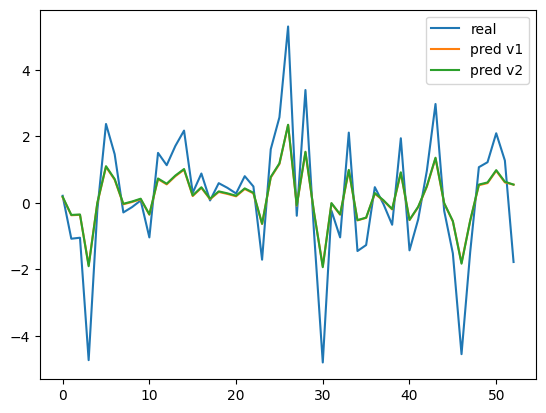

In [116]:
plt.plot(y_test_super_normal_v1, label='real')
plt.plot(y_pred_super_v1_shifted, label='pred v1')
plt.plot(y_pred_super_v2_shifted, label='pred v2')
plt.legend()
plt.show()

En el caso de la gasolina super, el primer modelo tiene un mejor desempeño.

# Discusión
Los resultados obtenidos con estos modelos tienen diferencias mínimas. En ambos casos se utilizaron LSTM para predecir los precios con un R2 de ~0.62. A pesar de que los resultados no son los mejores, se puede observar que el modelo LSTM es capaz de predecir los precios de los combustibles con un margen de error aceptable. También, se puede apreciar que, la diferencia entre las arquitecturas son mínimas, en ambos casos realizaron predicciones tan similares que las diferencias en las métricas de desempeño se encuentran en las centésimas/milésimas.

El único caso destacable (aunque no reflejado en las métricas) es en el del primer modelo para el Diesel, pues parece "adaptarse mejor" a los valores que tienen un cambio brusco en la serie de tiempo. En cuanto a métricas podríamos escoger cualquier modelo para realizar predicciones, por lo que para tomar una decisión más acertada usaremos el criterio de recursos computacionales.

Podemos ver que la segunda arquitectura tiene más capas y, por lo tanto, más parámetros que tunear. El proceso de _cross validation_ y, en consecuencia, de entrenamiento se dio más rápido con el primer modelo. En cualquier situación se escogería la arquitectura del primer modelo.

En cuanto a la comparación con los modelos de ARIMA y Prophet podemos observar que, al igual que los modelos LSTM, todos los modelos lograron predecir con bastante exactitud los diferentes cambios bruscos que sufren los precios de los diferentes combustibles.

El modelo ARIMA fue el más rápido de todos a la hora de su entrenamiento, y logró conseguir resultados bastante decentes que predicen con bastante exactitud los cambios, pero este no logra predecir con tanta exactitud los precios exactos para los combustibles como lo haría un modelo LSTM o Prophet.

El modelo de Prophet fue mucho más rápido y mucho más fácil de configurar que los modelos LSTM. Este obtuvo el resultado más preciso de los tres modelos mencionados, adaptándose bien tanto a los cambios bruscos como logrando predecir con exactitud el precio en los picos y valles dichos cambios.